In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch import optim
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision
from PIL import Image

In [2]:
!wget https://datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com/+day3/food_data.zip
!unzip food_data.zip 

--2021-01-26 16:04:35--  https://datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com/+day3/food_data.zip
Resolving datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com (datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com)... 52.219.0.63
Connecting to datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com (datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com)|52.219.0.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208150490 (199M) [application/zip]
Saving to: ‘food_data.zip’

food_data.zip       100%[===================>] 198.51M  63.2MB/s    in 3.1s    

2021-01-26 16:04:38 (63.2 MB/s) - ‘food_data.zip’ saved [208150490/208150490]

Archive:  food_data.zip
   creating: food_data/
   creating: food_data/test/
   creating: food_data/test/test/
  inflating: food_data/test/test/1-23.jpg  
  inflating: food_data/test/test/1-8.jpg  
  inflating: food_data/test/test/3-26.jpg  
  inflating: food_data/test/test/4-13.jpg  
  in

In [10]:
BATCH_SIZE = 48
#BATCH_SIZE = 128
traindata = torchvision.datasets.ImageFolder(root='food_data/train',
                        transform=transforms.Compose([
                                transforms.Resize((224,224), interpolation=Image.BICUBIC),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ])
                        )
trainloader = torch.utils.data.DataLoader(dataset=traindata, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# テストデータ
validdata = torchvision.datasets.ImageFolder(root='food_data/train',
                        transform=transforms.Compose([
                                transforms.Resize((224,224), interpolation=Image.BICUBIC),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ])
                        )
validloader = torch.utils.data.DataLoader(dataset=validdata, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1358, 1810, 3)


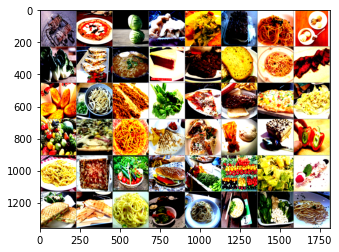

Dessert Bread Vegetable-Fruit Dessert Vegetable-Fruit Dessert Noodles-Pasta Dessert Vegetable-Fruit Bread Noodles-Pasta Dessert  Meat Bread Noodles-Pasta  Meat Bread Noodles-Pasta Dessert Vegetable-Fruit Bread  Meat Bread Vegetable-Fruit Vegetable-Fruit Bread Noodles-Pasta Bread Bread Dessert Dessert Vegetable-Fruit Noodles-Pasta Bread Vegetable-Fruit Bread Vegetable-Fruit Vegetable-Fruit Vegetable-Fruit Dessert Bread Bread Noodles-Pasta  Meat Noodles-Pasta Noodles-Pasta Vegetable-Fruit Noodles-Pasta


In [11]:
classes = ['Bread', 'Dessert', 'Meat', 'Noodles-Pasta',  'Vegetable-Fruit']


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [12]:
model = models.vgg16(pretrained=True)

In [13]:
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 18432),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(18432, 18432),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(18432, 5),
)

In [5]:
model.classifier = nn.Sequential(
    nn.Conv2d(4, 28, 2, 1, padding=1),
    nn.BatchNorm2d(28),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=28, out_channels=32, kernel_size=2, padding=1) ,
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout2d(0.25),
    #Flatten(),
    nn.Linear(18432, 100),
    nn.ReLU(),
    #nn.Dropout2d(0.5),
    nn.Linear(100, 5),
)

In [14]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [15]:
device = torch.device('cuda')
model = model.to(device)

In [16]:
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
for epoch in range(20):
    running_loss = 0.0
    correct_num = 0
    total_num = 0
    for i, (data, target) in enumerate(trainloader):
        inputs, labels = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        predicted = torch.max(outputs.data, 1)[1]
        correct_num_temp = (predicted==labels).sum()
        correct_num += correct_num_temp.item()
        total_num += BATCH_SIZE
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 経過の出力
    print('epoch:%d loss: %.3f acc: %.3f' %
        (epoch + 1, running_loss / 100, correct_num*100/total_num))

# モデルの保存
torch.save(model.state_dict(), 'sample.pt')

# テストデータ精度出力
model.eval()
correct_num = 0
total_num = 0
for i, (data, target) in enumerate(validloader):
    inputs, labels = data.to(device), target.to(device)
    outputs = model(inputs)
    predicted = torch.max(outputs.data, 1)[1]
    correct_num_temp = (predicted == labels).sum()
    correct_num += correct_num_temp.item()
    total_num += BATCH_SIZE

print('test acc: %.3f' % (correct_num * 100 / total_num))

epoch:1 loss: 0.473 acc: 60.322
epoch:2 loss: 0.193 acc: 84.848
epoch:3 loss: 0.122 acc: 90.057
epoch:4 loss: 0.077 acc: 94.508
epoch:5 loss: 0.024 acc: 97.917
epoch:6 loss: 0.013 acc: 98.580
epoch:7 loss: 0.004 acc: 99.290
epoch:8 loss: 0.002 acc: 99.432
epoch:9 loss: 0.001 acc: 99.432
epoch:10 loss: 0.001 acc: 99.432
epoch:11 loss: 0.001 acc: 99.432
epoch:12 loss: 0.000 acc: 99.432
epoch:13 loss: 0.000 acc: 99.432
epoch:14 loss: 0.000 acc: 99.432
epoch:15 loss: 0.000 acc: 99.432
epoch:16 loss: 0.000 acc: 99.432
epoch:17 loss: 0.000 acc: 99.432
epoch:18 loss: 0.000 acc: 99.432
epoch:19 loss: 0.000 acc: 99.432
epoch:20 loss: 0.000 acc: 99.432
test acc: 99.432


In [19]:
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for valid_xx, valid_yy in validloader:

        # device = "cuda"の場合、GPUにデータを転送する
        valid_xx = valid_xx.to(device)
        valid_yy = valid_yy.to(device)

        outputs = model(valid_xx)
        #outputs = net(valid_xx)
        _, predicted = torch.max(outputs.data, 1)

        all_labels = np.append(all_labels, valid_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())

        total += valid_yy.size(0)
        true += (predicted == valid_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

Accuracy: 100.00 %


In [20]:
testset = torchvision.datasets.ImageFolder(root='food_data/test',
                        transform=transforms.Compose([
                                transforms.Resize((224,224), interpolation=Image.BICUBIC),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ])
                        )

testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=4, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)